In [1]:
#!pip install opencv-python
#!pip install tensorflow
#!pip install image_similarity_measures

import sys
import numpy as np 
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
import keras.utils as image
import image_similarity_measures
from image_similarity_measures.quality_metrics import rmse, ssim, sre

In [2]:
file_path = "test.zip"
output = file_path
if not os.path.exists("Test Set/"):
    gdown.download("https://drive.google.com/uc?id=1W94tVozlrHMY_SWE-45TvWT5PqQjElxc", file_path)
    gdown.extractall(file_path)
    if os.path.exists(file_path):
        os.remove(file_path)

In [3]:
gender_img_height = 378
gender_img_width = 378
emotions_img_height = 224
emotions_img_width = 224
gender_class_names = ["Man", "Woman"]
emotions_class_names = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

In [4]:
#Load the Model
file_path = "test.zip"
if not os.path.exists("Gender Model/"):
    gdown.download("https://drive.google.com/uc?id=1easVnhBN9o1s60_eAyl8CGj_LHuPoXgc", file_path)
    gdown.extractall(file_path)
    if os.path.exists(file_path):
        os.remove(file_path)
gender_model = keras.models.load_model('Gender Model/')

#Load the Model
file_path = "test.zip"
if not os.path.exists("Emotions Model/"):
    gdown.download("https://drive.google.com/uc?id=1zwwyyd0CZZBDOYt6vSliejyq7NrGbRsT", file_path)
    gdown.extractall(file_path)
    if os.path.exists(file_path):
        os.remove(file_path)
emotions_model = keras.models.load_model('Emotions Model/')

In [71]:
import warnings
warnings.filterwarnings("ignore")

def prepare_img(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    return images

def write_on_box(frame, gender, x, y, h, emotions):
    c = 10
    cv2.putText(frame, gender, (x, y+h+25), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    for key, value in emotions.items():    
        cv2.putText(
            frame, 
            str(key) + " " + str(value)[:-5], 
            (x, y-c), 
            cv2.FONT_HERSHEY_SIMPLEX, 
            0.9, 
            (36,255,12), 
            2
        )
        c += 30

def plotChart(emotions, gender, emotions_classes, live):
    global history
    tmp_emotions_class_names = np.insert(emotions_class_names, 6, "")
    tmp_emotions_classes = np.insert(emotions_classes.flatten(), 6, 0)
    fig = plt.figure(figsize=[8, 8])
    ax = fig.add_subplot(111, projection='polar')
    ax.set_xticklabels(tmp_emotions_class_names)
    theta = np.arange( 0, 2*np.pi, 2*np.pi/8)
    for key in emotions.keys():
        i = np.where(tmp_emotions_class_names == key)[0][0]
        ax.plot([0, theta[i]], [0, tmp_emotions_classes[i]], 'o-')

    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img  = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    if live:
        cv2.imshow("chart", img)
        ax.set_visible(False)
        history = np.append(history, {"Gender": gender, **emotions})

def calc_closest_val(d, checkMax):
    result = {}

    if (checkMax):
        closest = max(d.values())
    else:
        closest = min(d.values())
    
    for key, value in d.items():
        if (value == closest):
            result[key] = closest
            
    return result

def find_gender(img):
    gender_classes = gender_classes_f(img)
    return gender_class_names[np.where(gender_classes > 0.5, 1,0)[0][1]]

def find_emotions(img):
    tmp_dictionary = dict()
    emotions = dict()
    emotions_classes = emotions_classes_f(img)
    index = list(np.where(np.where(emotions_classes > 0.8, 1, 0)[0] == 1)[0])
    for i in index:
        tmp_dictionary[emotions_class_names[i]] = emotions_classes[0][i]
    sorted_keys = sorted(tmp_dictionary, key=tmp_dictionary.get, reverse=True)
    for w in sorted_keys:
        emotions[w] = tmp_dictionary[w]
    return emotions

def emotions_classes_f(img):
    emotions_img = cv2.resize(np.float32(img), (emotions_img_height, emotions_img_width))
    return emotions_model.predict(prepare_img(emotions_img))

def gender_classes_f(img):
    gender_img = cv2.resize(np.float32(img), (gender_img_height, gender_img_width))
    return gender_model.predict(prepare_img(gender_img))

def calc_similarity(template_faces):
    ssim_measures = dict()
    rmse_measures = dict()
    sre_measures = dict()
    for key in template_faces.keys():
        resized_img = cv2.resize(template_faces[key], dim, interpolation = cv2.INTER_AREA)
        ssim_measures[key]= ssim(face, resized_img)
        rmse_measures[key]= rmse(face, resized_img)
        sre_measures[key]= sre(face, resized_img)
    ssim_dict = calc_closest_val(ssim_measures, True)
    rmse_dict = calc_closest_val(rmse_measures, False)
    sre_dict = calc_closest_val(sre_measures, True)
    print(ssim_dict, rmse_dict, sre_dict)
    key1 = next(iter(ssim_dict))
    key2 = next(iter(rmse_dict))
    key3 = next(iter(sre_dict))

    if key1 == key2 or key1 == key3:
        if ssim_dict[key1] > 0.9:
            return key1
        else:
            return ""
    if key2 == key3:
        if sre_dict[key3] > 57:
            return key2
        else:
            return ""
    if key1 != key2 and key1 != key3 and key2 != key3:
        if ssim_dict[key1] > 0.9:
            return key1
        else:
            return ""

def new_person(template_faces, history_dict, faces_index, face, history):
    template_faces[f"Person{faces_index}"] = face
    history_dict[f"Person{faces_index}"] = history
    faces_index += 1
    return (template_faces, history_dict, faces_index)

1/1 [==============================] - 0s 76ms/step
Woman 'Happy': 0.9999998, 'Disgust': 0.9894922, 'Neutral': 0.85764444
1/1 [==============================] - 0s 21ms/step


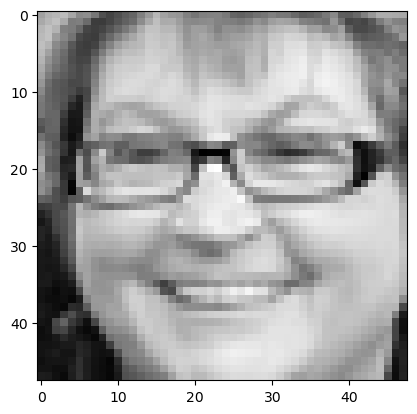

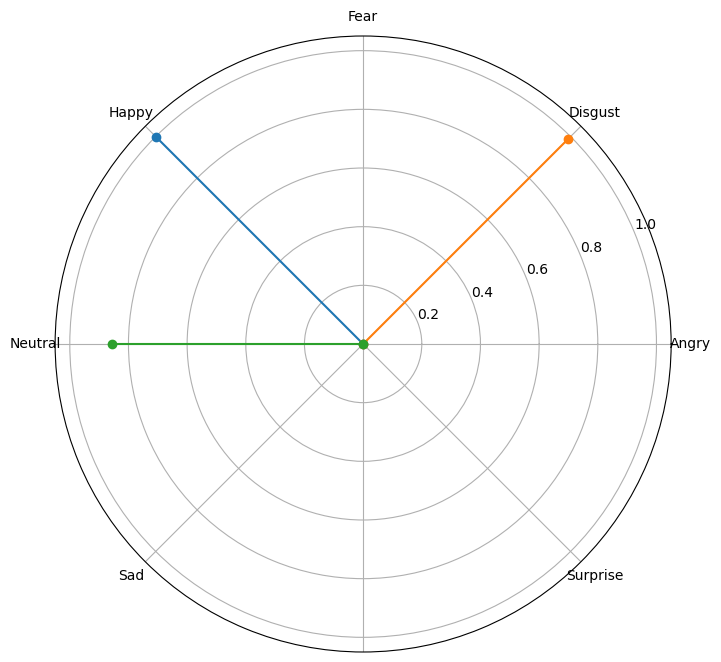

In [6]:
## Load and Predict an image
img = image.load_img("Test Set/100.png", color_mode = "grayscale")

gender = find_gender(img)
emotions = find_emotions(img)

print(gender + " " + str(emotions)[1:-1])

plt.imshow(img, cmap="gray")

plotChart(emotions, gender, emotions_classes_f(img), False)

1/1 [==============================] - 0s 23ms/step
{'Person1': 0.8854432868075559} {'Person1': 0.013287861} {'Person1': 46.91373298369193}
1/1 [==============================] - 0s 25ms/step
{'Person2': 0.9365895552186313} {'Person2': 0.008244395} {'Person2': 48.35450000625383}
1/1 [==============================] - 0s 24ms/step
{'Person2': 0.9445362646999055} {'Person2': 0.007806992} {'Person2': 48.56495723810825}
1/1 [==============================] - 0s 23ms/step
{'Person2': 0.9739316502862975} {'Person2': 0.0049915817} {'Person2': 50.69363675961418}
1/1 [==============================] - 0s 22ms/step
{'Person2': 0.9741143618705079} {'Person2': 0.004937762} {'Person2': 50.77335546524957}
1/1 [==============================] - 0s 22ms/step
{'Person2': 0.980890136044852} {'Person2': 0.0043153544} {'Person2': 51.34646785250218}
1/1 [==============================] - 0s 21ms/step
{'Person2': 0.9749134004992209} {'Person2': 0.0048596323} {'Person2': 50.83406707751995}


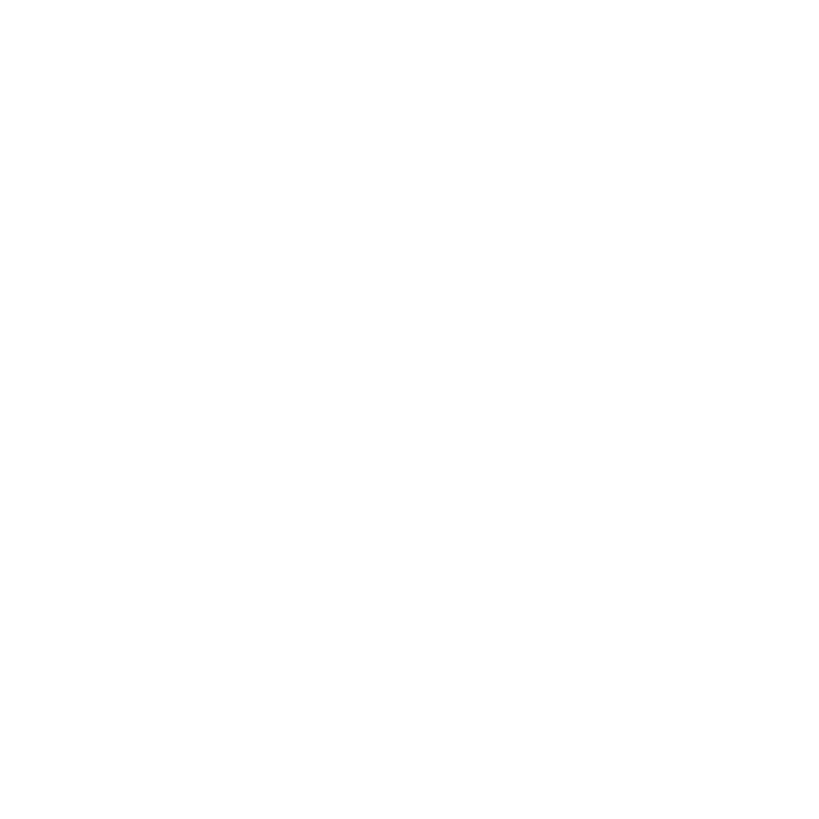

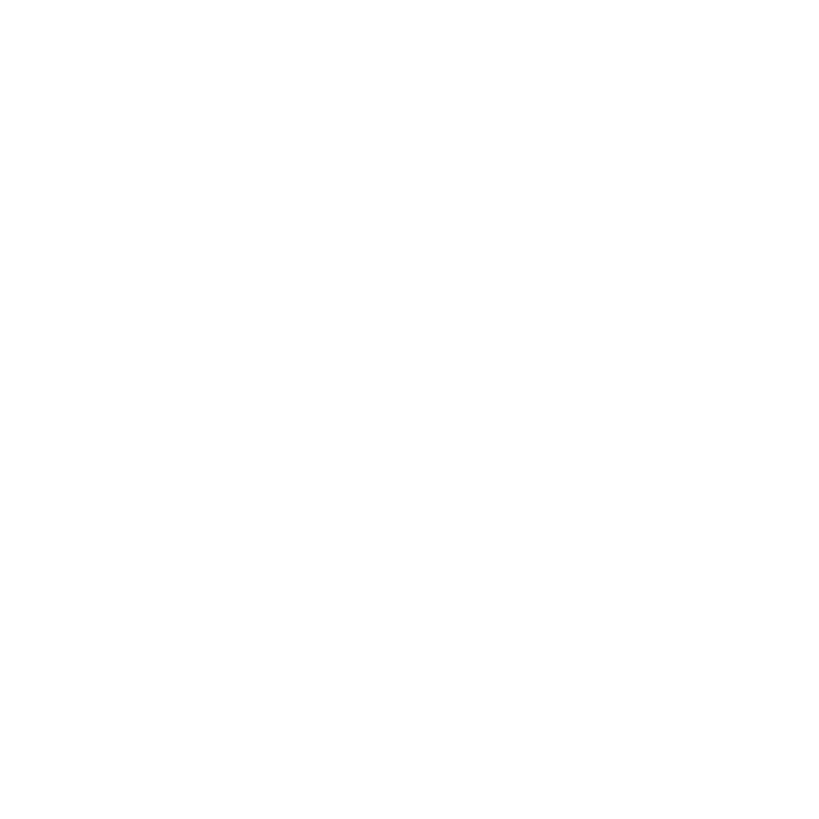

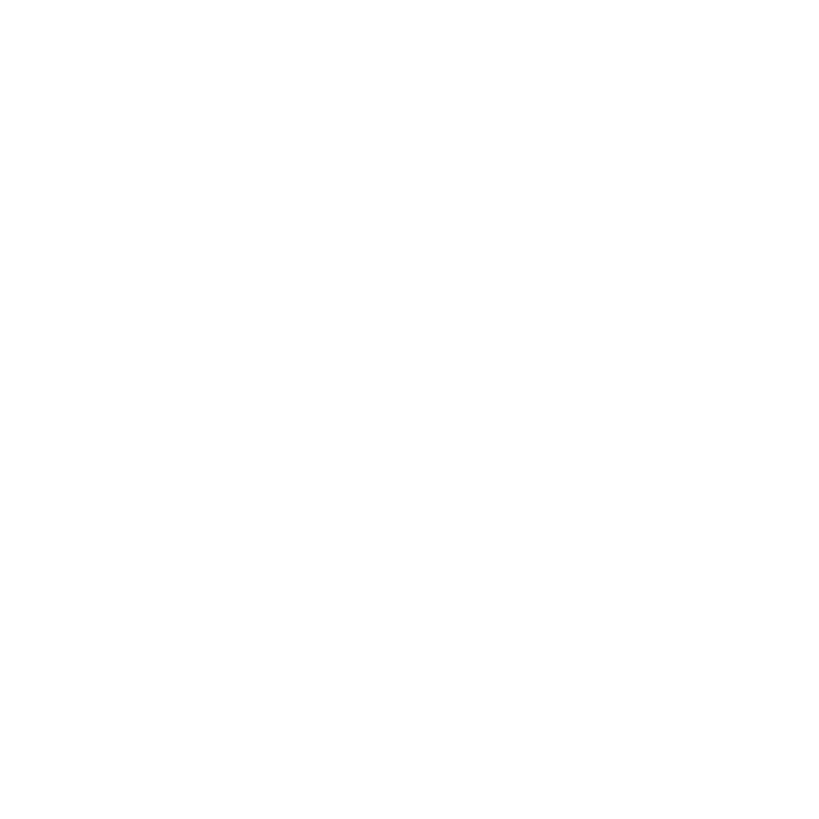

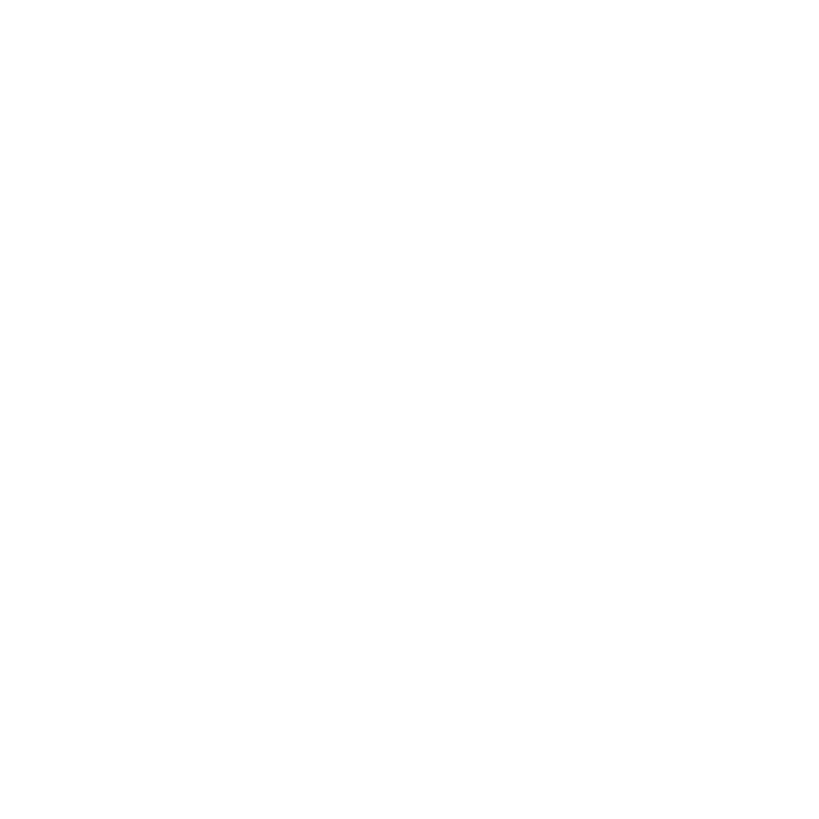

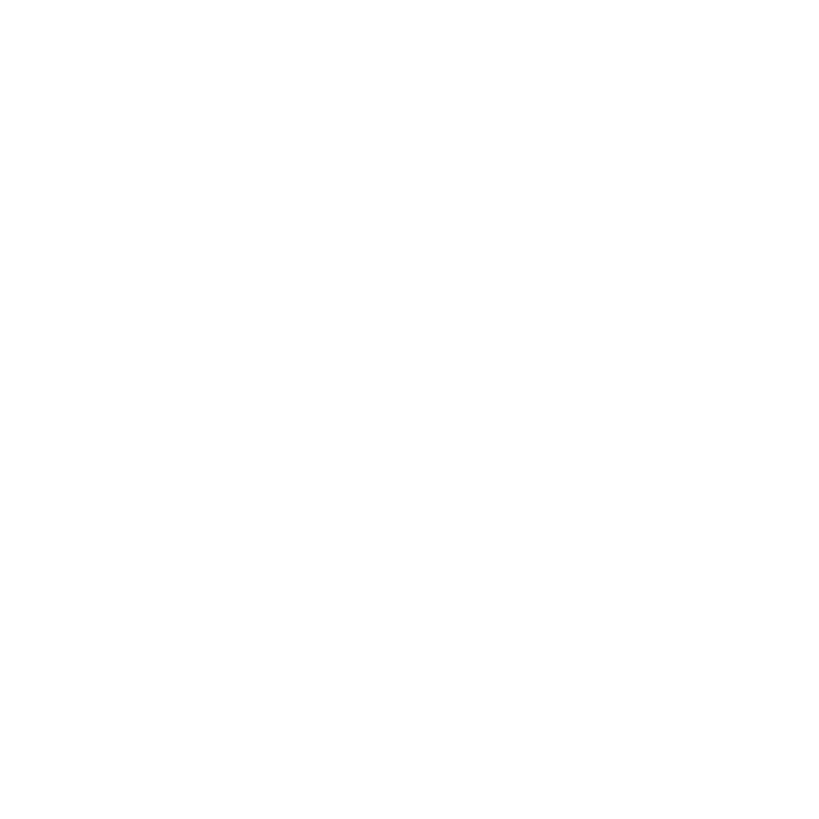

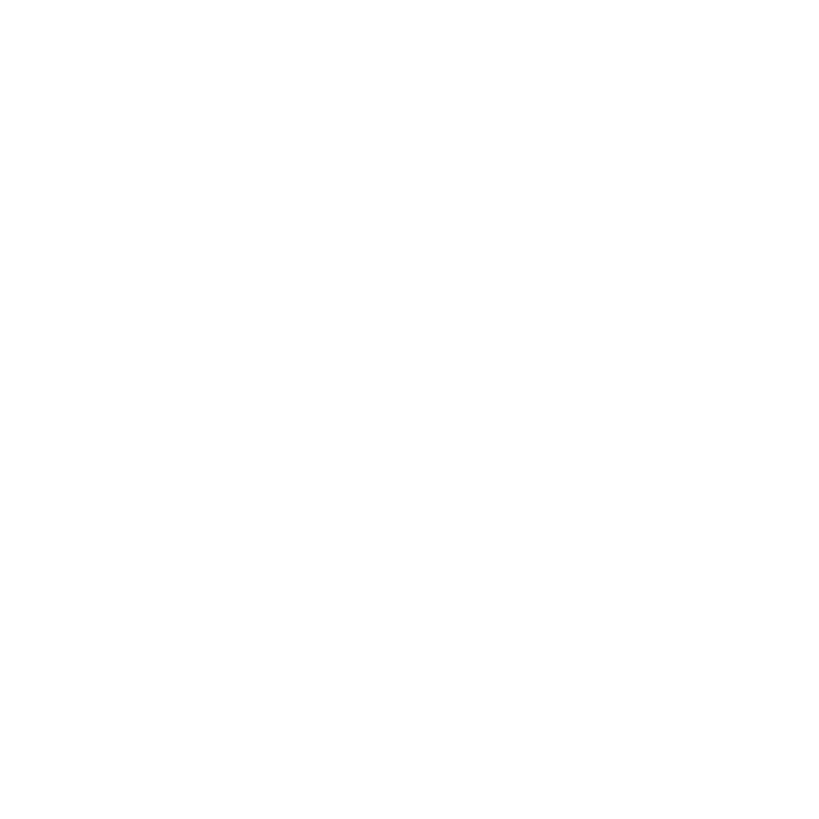

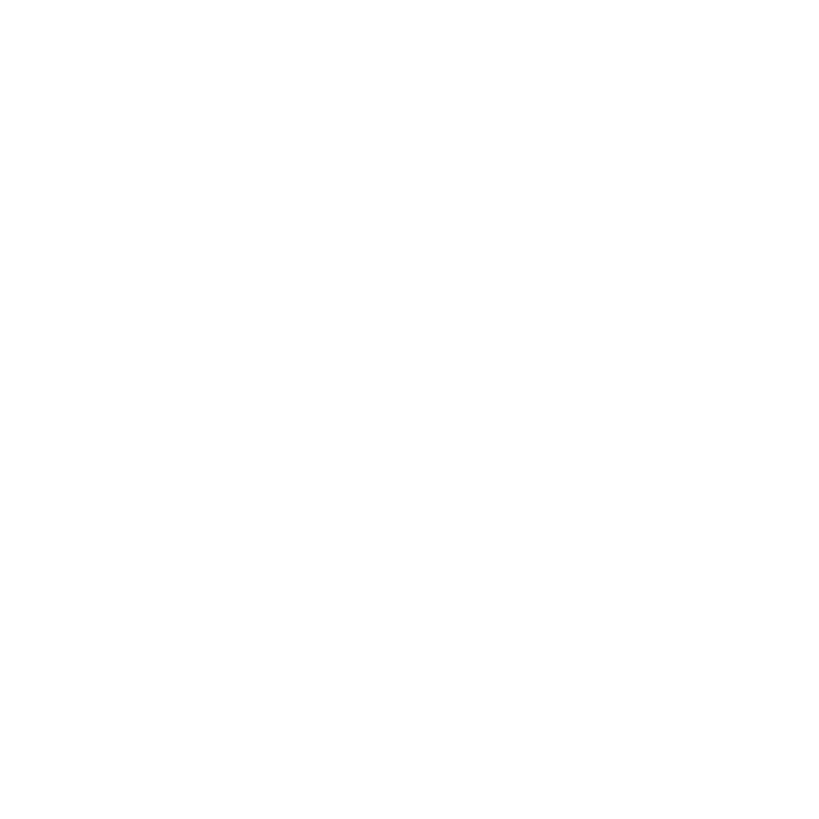

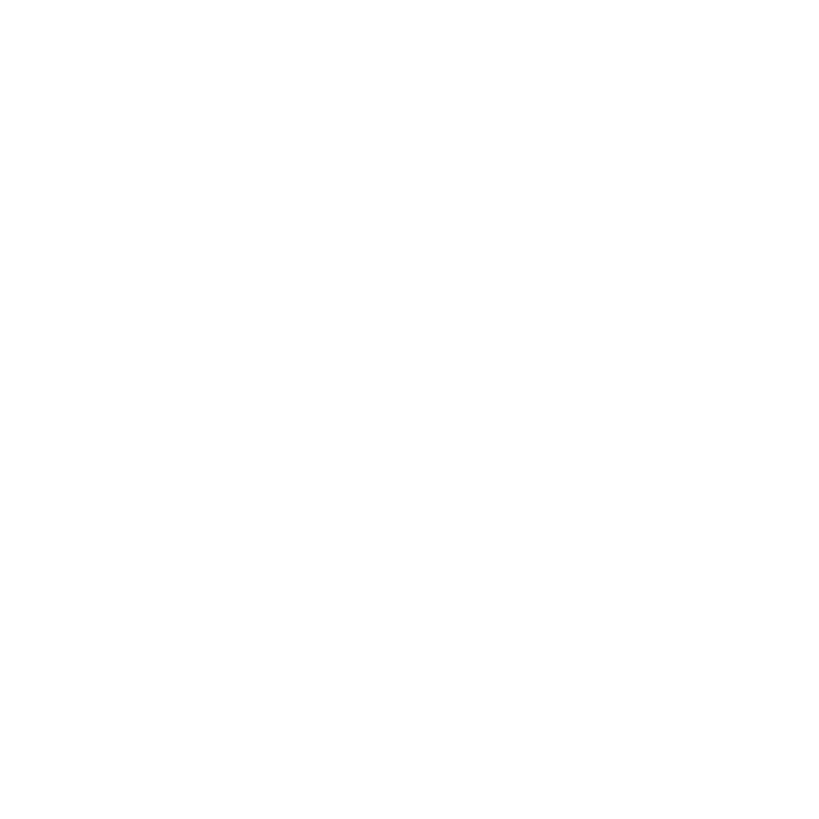

In [74]:
cap = cv2.VideoCapture(0)

if (cap.isOpened() == False): 
    print("Unable to read camera feed")

face_cascade = cv2.CascadeClassifier('Face Weights/haarcascade_frontalface_alt.xml')

skip_frames = int(cap.get(cv2.CAP_PROP_FPS))
cur_frames = 0

template_faces = dict()
faces_index = 1
history_dict = dict()

while True:
    ret, frame = cap.read()
    
    if ret:
        process_frame = cur_frames % skip_frames == 0
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        faces = face_cascade.detectMultiScale(frame)
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            if process_frame:
                history = np.array([])
                face = frame[y:y+h, x:x+w]
                face_gray = gray[y:y+h, x:x+w]
                dim = (int(face.shape[1]),int(face.shape[0]))
                
                gender = find_gender(face_gray)
                emotions = find_emotions(face_gray)
                
                write_on_box(frame, gender, x, y, h, emotions)
                
                plotChart(emotions, gender, emotions_classes_f(face_gray), True)
                
                if len(template_faces) > 0:
                    key = calc_similarity(template_faces)
                    if key in history_dict:
                         history_dict[key] = np.append(history_dict[key], history)
                    else:
                        template_faces, history_dict, faces_index = new_person(template_faces, history_dict, faces_index, face, history)
                else:
                    template_faces, history_dict, faces_index = new_person(template_faces, history_dict, faces_index, face, history)
            else:
                write_on_box(frame, gender, x, y, h, emotions)
        cv2.imshow('frame', frame)
        cur_frames += 1
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cap.release()
            break
    else:
        break

cap.release()
cv2.destroyAllWindows()


In [75]:
history_dict

{'Person1': array([{'Gender': 'Woman', 'Neutral': 0.9945235, 'Sad': 0.95991266, 'Angry': 0.8149633}],
       dtype=object),
 'Person2': array([{'Gender': 'Woman', 'Neutral': 0.99927634, 'Sad': 0.9899946, 'Angry': 0.839013},
        {'Gender': 'Woman', 'Angry': 0.91416335},
        {'Gender': 'Woman', 'Angry': 0.993956, 'Fear': 0.89310956, 'Disgust': 0.85042876},
        {'Gender': 'Woman', 'Neutral': 0.99864435, 'Sad': 0.98481935, 'Angry': 0.8385133},
        {'Gender': 'Woman', 'Neutral': 0.99785775, 'Sad': 0.97995305, 'Angry': 0.8125791},
        {'Gender': 'Woman', 'Neutral': 0.99927974, 'Sad': 0.9826873, 'Angry': 0.80199444},
        {'Gender': 'Woman', 'Neutral': 0.9994288, 'Sad': 0.9806871, 'Angry': 0.818698}],
       dtype=object)}